## 02 - Portefeuille de Markowitz appliqué au PEA

Ce notebook vise à trouver l'allocation optimale d'un portefeuille de $x$ euros sur la base des performances des 3 dernières années uniquement et en restreignant le choix des actifs aux seuls titres éligibles au PEA. 

Afin de limiter le coût computationnel, on s'interesse à un nombre restreint d'actifs financiers:

- Les 10 actions EURONEXT qui ont affiché les meilleures performances sur les 3 dernières années. La performance est mesurée par le seul ratio de sharpe (return / vol).

- Sélection d'une quinzaine d'ETF éligibles au PEA. Ces ETF doivent permettrent de diversifier l'investissement en introduisant des obligations et de l'exposition aux différentes régions du monde (autrement pas disponibles dans un PEA).

In [2]:
## SELECTION DES 10 TITRES EURONEXT (SHARP RATIO)
## A partir des données de prix préalablement téléchargées

import glob
import pandas as pd
import numpy as np
from stock_analysis import *

% cd /Users/nsaleille/Sites/stocks/

dfs = [pd.read_csv(f, sep = ";", index_col = 'Date') for f in glob.glob("data/euronext-stock-data-*.csv")]
df_open = pd.concat(dfs, axis = 1, sort = True)
df_open.drop('IAM.PA', axis = 1, inplace = True) # Maroc Telecom pas éligible PEA

df_log_returns = np.log(df_open / df_open.shift(1))
df_log_returns.dropna(inplace = True, how = 'all')
df_log_returns = df_log_returns.loc[df_log_returns.index > '2017-03-01']

for col in df_log_returns:
    try:
        if df_log_returns[col].first_valid_index() > '2017-03-02':
            df_log_returns.drop(col, axis =1, inplace = True)
    except:
        df_log_returns.drop(col, axis =1,inplace = True)
        continue

df_sharp_ratio = df_log_returns.mean()*252 / np.sqrt(df_log_returns.var()*252)
top_tickers = df_sharp_ratio.sort_values(ascending = False).head(9).index.tolist()
euronext_top_tickers = pd.Series(top_tickers, index = top_tickers).to_dict()
euronext_top_tickers

/Users/nsaleille/Sites/stocks


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


{'CCN.PA': 'CCN.PA',
 'CDI.PA': 'CDI.PA',
 'CIV.PA': 'CIV.PA',
 'CRSU.PA': 'CRSU.PA',
 'GENX.PA': 'GENX.PA',
 'GRVO.PA': 'GRVO.PA',
 'GTT.PA': 'GTT.PA',
 'SAF.PA': 'SAF.PA',
 'TEP.PA': 'TEP.PA'}

In [3]:
## TELECHARGEMENT DES DONNEES SUR 3 ANS AVEC YFINANCE

import pandas as pd
import seaborn as sns
import yfinance as yf

start, end = ['2017-03-01', '2020-03-04']

yahoo_tickers = {
    'AMUNDI PEA NASDAQ': 'PANX.PA',
    'AMUNDI ETF CAC 40' : 'C40.PA',
    'AMUNDI ETF SP 500' : '500.PA',
    'AMUNDI ETF EM AS U': 'AASU.PA',
    'AMUNDI ETF STOX600': 'C6E.PA',
    'AMUNDI SP500 H EUR' : '500H.PA',
    'AMUNDI ETF MSCI EM' : 'AEEM.PA',
    'AMUNDI TOPIX HDG' : 'TPXH.PA',
    'AMUNDI RUSSEL 2K':'RS2K.PA',
    'AMUNDI PEA EM ASIA' : 'PAASI.PA',
    'AMUNDI ETF MS CHN' : 'CC1.PA',
    'AMUNDI MSCI BRAZIL': 'BRZ.PA',
    'LYXOR KOREA PEA' : 'PKRW.PA',
    'LYXOR INDIA PEA' : 'PINR.PA',
    'LYXOR PEA OBLI' : 'OBLI.PA',
    'AMUNDI PAC X JAP E' : 'CP9.PA',
    'LYXOR ETF DAX': 'DAX.PA',
    'LYXOR ETF BX4' : 'BX4.PA'
}

yahoo_tickers.update(euronext_top_tickers)

s = []
for name in yahoo_tickers:
    print('Download ticker data : {} ({})'.format(name, yahoo_tickers[name]))
    tick_hist = yf.Ticker(yahoo_tickers[name]).history(start = start, end = end)
    s.append(tick_hist['Open'])

df_open = pd.concat(s, axis = 1)
df_open.columns = yahoo_tickers.keys()

df_log_returns = np.log(df_open / df_open.shift(1))
df_log_returns.dropna(inplace = True, how = 'all')

Download ticker data : AMUNDI PEA NASDAQ (PANX.PA)
Download ticker data : AMUNDI ETF CAC 40 (C40.PA)
Download ticker data : AMUNDI ETF SP 500 (500.PA)
Download ticker data : AMUNDI ETF EM AS U (AASU.PA)
Download ticker data : AMUNDI ETF STOX600 (C6E.PA)
Download ticker data : AMUNDI SP500 H EUR (500H.PA)
Download ticker data : AMUNDI ETF MSCI EM (AEEM.PA)
Download ticker data : AMUNDI TOPIX HDG (TPXH.PA)
Download ticker data : AMUNDI RUSSEL 2K (RS2K.PA)
Download ticker data : AMUNDI PEA EM ASIA (PAASI.PA)
Download ticker data : AMUNDI ETF MS CHN (CC1.PA)
Download ticker data : AMUNDI MSCI BRAZIL (BRZ.PA)
Download ticker data : LYXOR KOREA PEA (PKRW.PA)
Download ticker data : LYXOR INDIA PEA (PINR.PA)
Download ticker data : LYXOR PEA OBLI (OBLI.PA)
Download ticker data : AMUNDI PAC X JAP E (CP9.PA)
Download ticker data : LYXOR ETF DAX (DAX.PA)
Download ticker data : LYXOR ETF BX4 (BX4.PA)
Download ticker data : CCN.PA (CCN.PA)
Download ticker data : CDI.PA (CDI.PA)
Download ticker data 

On vérifie que les données téléchargées sont correctes en visualisant les séries et la distribution des rendements. La comparaison des distributions permet de visualiser clairement le niveau de volatilité des titres (degré d'applatissement). 

/Users/nsaleille/Library/Python/3.6/lib/python/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


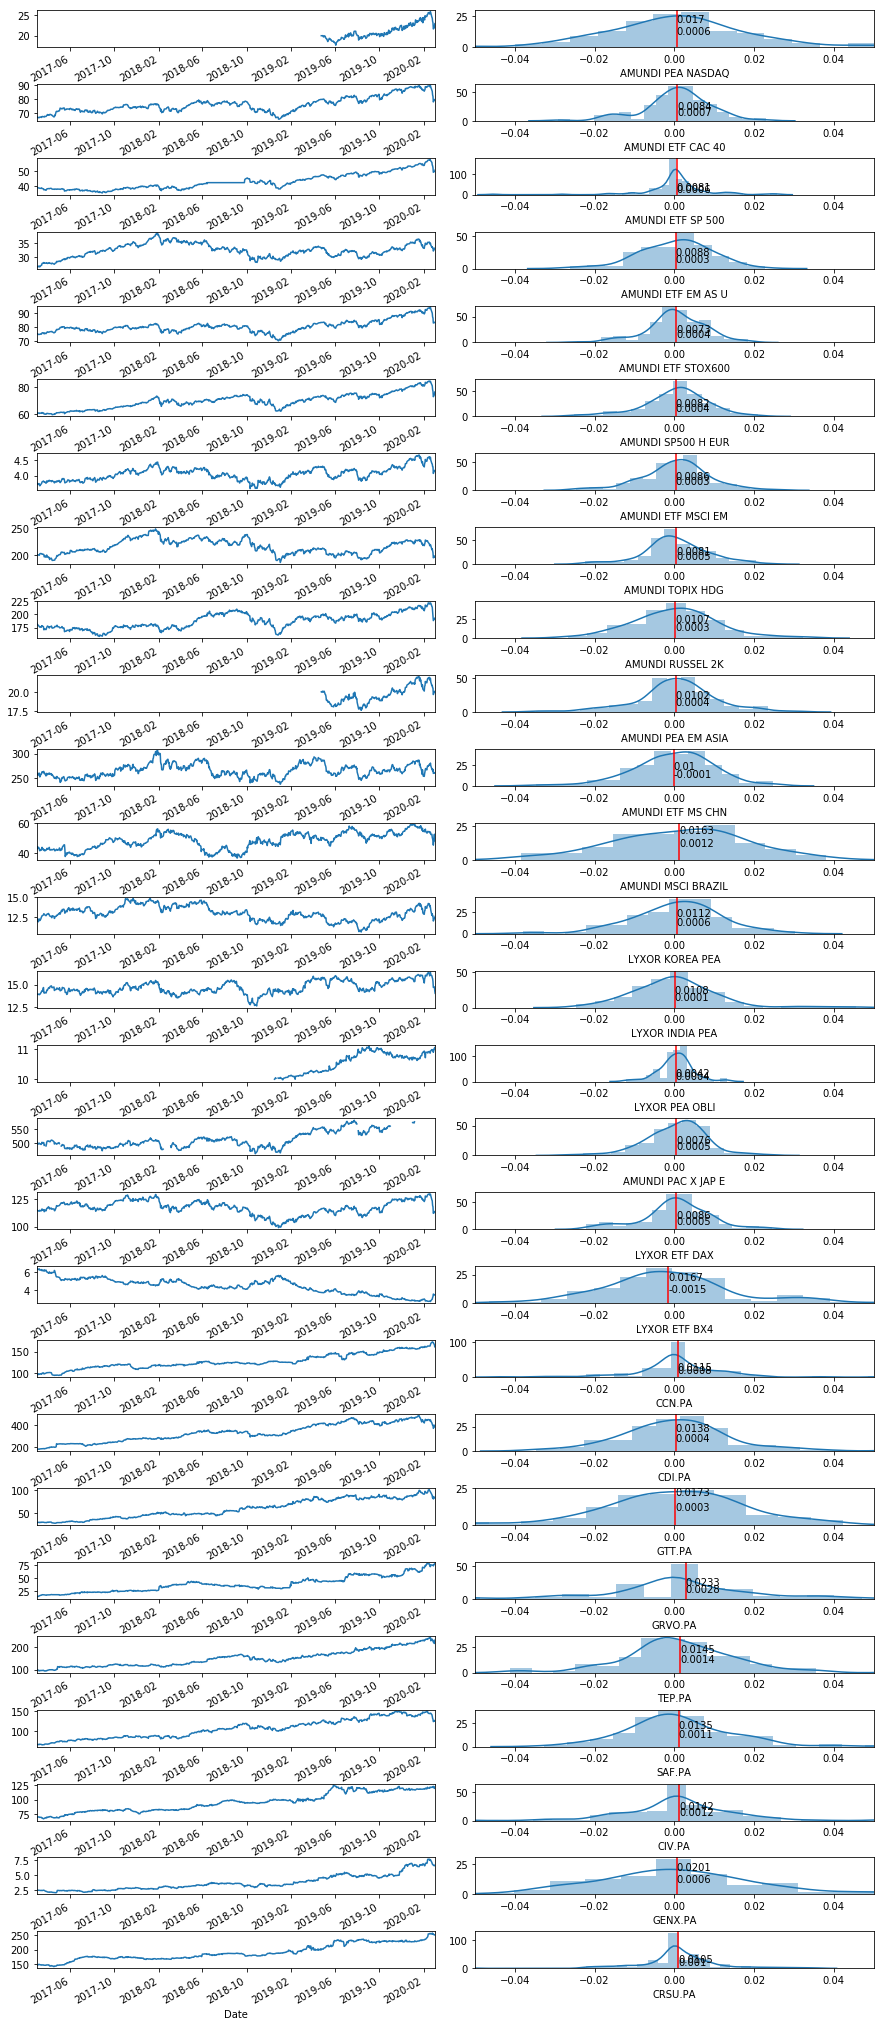

In [4]:
import numpy as np
import matplotlib.pyplot as plt


def dist_fig(df_open):
    
    #df_log_returns = (df_open / df_open.shift(1)).applymap(np.log).dropna()
    df_log_returns = (df_open.diff(1) / df_open.shift(1)).dropna()
    
    fig, axs = plt.subplots(df_open.shape[1],2, figsize=(15, 40), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 1, wspace=.1)
    axs, i = axs.ravel(), 0

    for col in df_open:
        df_open[col].plot(ax=axs[i])
        i += 1
        distplot = sns.distplot(df_log_returns[col], ax=axs[i])
        distplot.axvline(df_log_returns[col].mean(), color = 'r', label = 'test')
        distplot.text(df_log_returns[col].mean(),10,str(round(df_log_returns[col].mean(), 4)))
        distplot.text(df_log_returns[col].mean(),20,str(round(df_log_returns[col].std(), 4)))
        distplot.set(xlim = [-0.05, +0.05])

        i += 1
    plt.show()
    return None

dist_fig(df_open)

Globalement les séries sont fortement corrélées entre-elles, ce qui limitera les gains tirés de la diversification geographique et sectorielle. On remarque néanmoins que les ETF r/ aux pays émergents, à la Chine ou à la Corée du Sud sont les moins corrélés aux marchés US et FR.

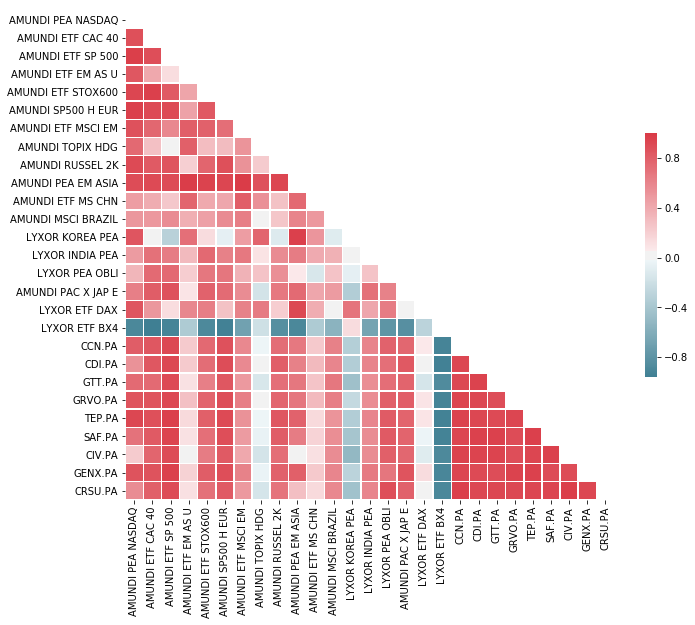

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Compute the correlation matrix
corr = df_open.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

On peut également construire la frontière d'efficience du [modèle de Markowitz](https://en.wikipedia.org/wiki/Markowitz_model) et chercher le portefeuille avec le meilleur ratio de sharpe.

In [6]:
from scipy.optimize import minimize

def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(df_log_returns.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(df_log_returns.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

cons = ({'type':'eq', 'fun': check_sum})
bounds = [(0,1)]*df_log_returns.shape[1]
init_guess = [0.25]*df_log_returns.shape[1]

low_risk_asset_return = df_log_returns.mean()[np.argmin(df_log_returns.std())]

frontier_y = np.linspace((low_risk_asset_return * 252),(df_log_returns.mean() * 252).max(),30)
frontier_x = []
frontier_w = []

for possible_return,i in zip(frontier_y, range(len(frontier_y))):
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])
    frontier_w.append(result['x'])
    print('Point {}/{} : return = {}, vol = {}'.format(i, len(frontier_y), round(possible_return, 4), round(result['fun'],4)))

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Point 0/30 : return = 0.0811, vol = 0.0312
Point 1/30 : return = 0.0978, vol = 0.0338
Point 2/30 : return = 0.1145, vol = 0.0368
Point 3/30 : return = 0.1311, vol = 0.0403
Point 4/30 : return = 0.1478, vol = 0.0443
Point 5/30 : return = 0.1644, vol = 0.0489
Point 6/30 : return = 0.1811, vol = 0.0539
Point 7/30 : return = 0.1978, vol = 0.0596
Point 8/30 : return = 0.2144, vol = 0.0658
Point 9/30 : return = 0.2311, vol = 0.0726
Point 10/30 : return = 0.2477, vol = 0.08
Point 11/30 : return = 0.2644, vol = 0.0877
Point 12/30 : return = 0.2811, vol = 0.0958
Point 13/30 : return = 0.2977, vol = 0.105
Point 14/30 : return = 0.3144, vol = 0.1152
Point 15/30 : return = 0.331, vol = 0.1263
Point 16/30 : return = 0.3477, vol = 0.138
Point 17/30 : return = 0.3644, vol = 0.1503
Point 18/30 : return = 0.381, vol = 0.163
Point 19/30 : return = 0.3977, vol = 0.1762
Point 20/30 : return = 0.4144, vol = 0.191
Point 21/30 : return = 0.431, vol = 0.2085
Point 22/30 : return = 0.4477, vol = 0.2282
Point 2

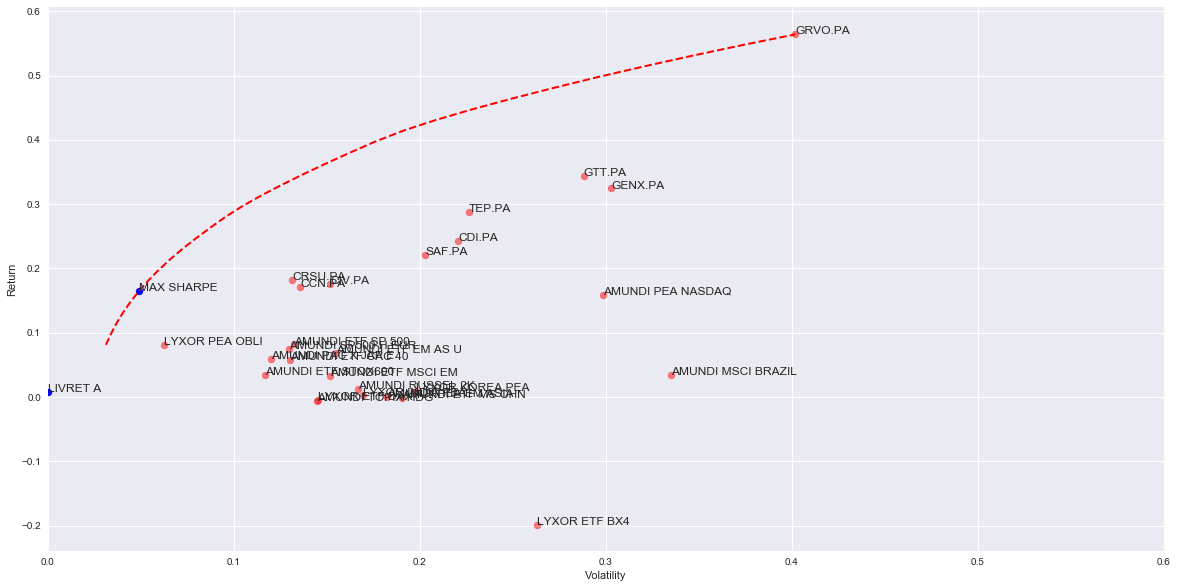

In [7]:
sns.set(rc={'figure.figsize':(11, 20)})

plt.figure(figsize=(20,10))
#plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
#plt.scatter(vol_arr[sharpe_arr.argmax()], ret_arr[sharpe_arr.argmax()],c='blue', s=50) # red dot

for col in df_log_returns:
    plt.annotate(col, (np.sqrt(df_log_returns[col].var()*252), df_log_returns[col].mean()*252))
    plt.scatter(x=np.sqrt(df_log_returns[col].var()*252), y=df_log_returns[col].mean()*252, alpha=0.5, color='red')

#plt.colorbar(label='Sharpe Ratio')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=2)
plt.scatter(x=0,y=0.0075, color = 'blue')
plt.annotate('LIVRET A', (0, 0.0075))

plt.scatter(x=frontier_x[np.argmax(frontier_y / frontier_x)], y=frontier_y[np.argmax(frontier_y / frontier_x)], color = 'blue')
plt.annotate('MAX SHARPE', (frontier_x[np.argmax(frontier_y / frontier_x)], frontier_y[np.argmax(frontier_y / frontier_x)]))

axes = plt.gca()
axes.set_xlim([0,0.6])
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

Le portefeuille optimal au sens de Markowitz contient environ 30% de LYXOR PEA OBLI et une dizaine de titres action. Attention néanmoins, ce résultat traduit uniquement le niveau des performances passées !!!

In [14]:
total_invested = 10000

df_markov = pd.concat([df_log_returns.mean()*252, np.sqrt(df_log_returns.var()*252), markov_port], axis = 1)
df_markov.columns = ['Average Return', 'Standard Dev', 'Markov Weight']
df_markov['Theoretical Value'] = df_markov['Markov Weight'] * total_invested
df_markov['Spot Price'] = df_open.loc[end]

df_markov.dropna(inplace = True)
df_markov['Units'] = (df_markov['Theoretical Value'] / df_markov['Spot Price']).apply(int)
df_markov['Portfolio Value'] = df_markov['Units'] * df_markov['Spot Price']

print('Valeur totale du portefeuille : {} euros'.format(sum(df_markov['Portfolio Value'])))
df_markov.sort_values(ascending = False, by = 'Markov Weight')

Valeur totale du portefeuille : 9315.455 euros


,Average Return,Standard Dev,Markov Weight,Theoretical Value,Spot Price,Units,Portfolio Value
LYXOR PEA OBLI,0.081140,0.062198,0.33,3300.0,11.0500,298,3292.900
CRSU.PA,0.182160,0.131394,0.10,1000.0,251.0000,3,753.000
CIV.PA,0.175582,0.151597,0.10,1000.0,119.5000,8,956.000
CCN.PA,0.170858,0.135605,0.08,800.0,161.0000,4,644.000
SAF.PA,0.221250,0.202775,0.06,600.0,127.1000,4,508.400
TEP.PA,0.288072,0.226366,0.06,600.0,234.0000,2,468.000
LYXOR ETF BX4,-0.199611,0.262910,0.06,600.0,3.5050,171,599.355
GENX.PA,0.324449,0.302934,0.05,500.0,6.7200,74,497.280
GRVO.PA,0.564298,0.401854,0.05,500.0,78.5000,6,471.000
AMUNDI ETF EM AS U,0.068549,0.154849,0.04,400.0,33.3100,12,399.720
